# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 500.0E-6 #50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 47.298 мкм


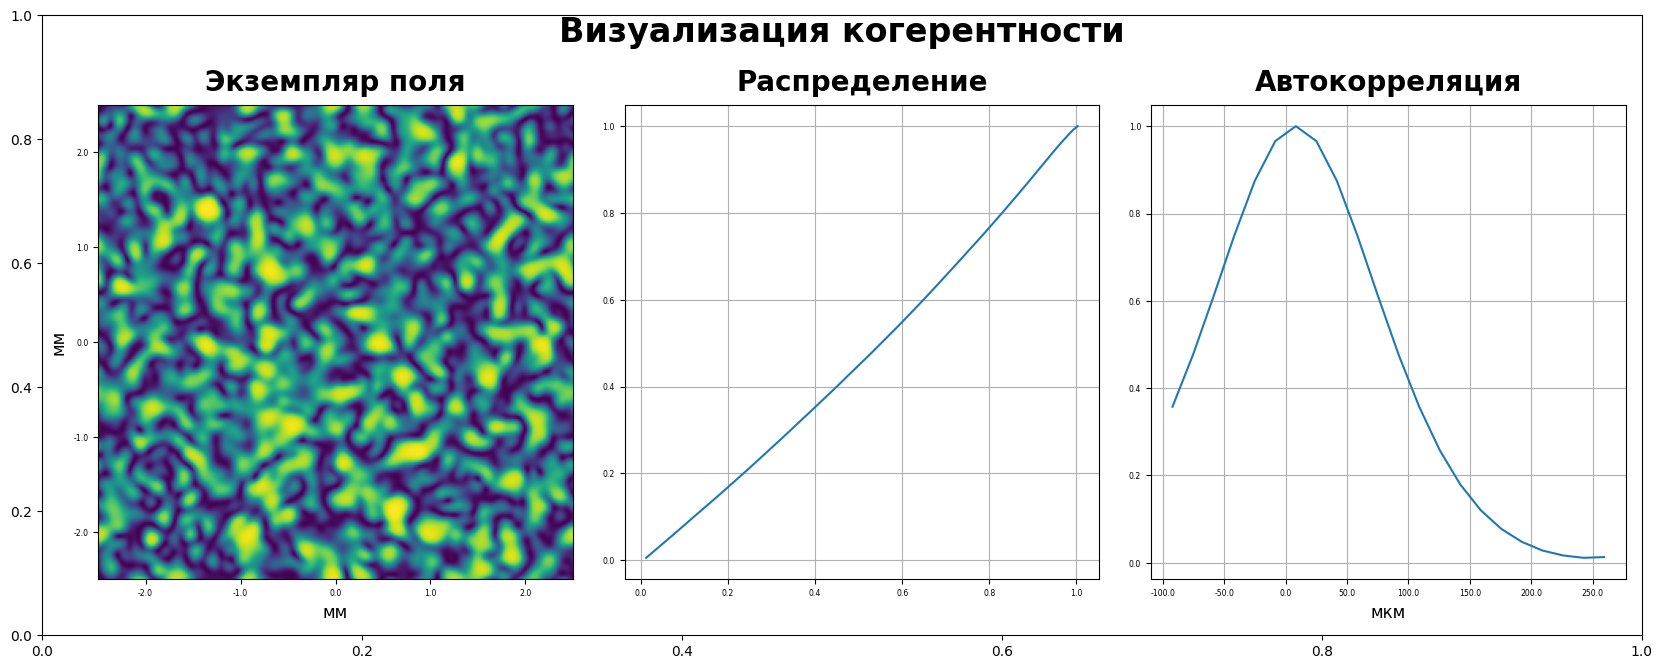

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

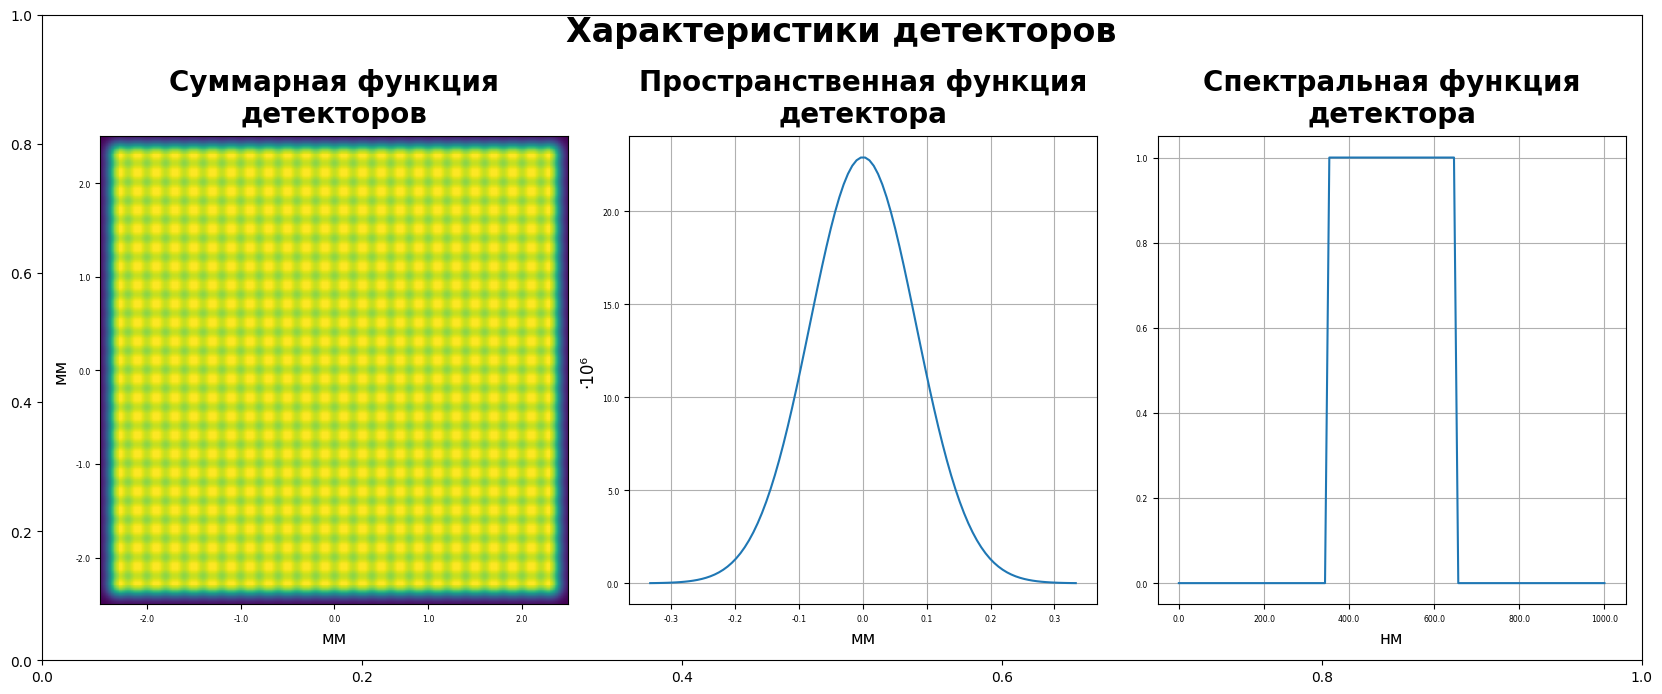

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]


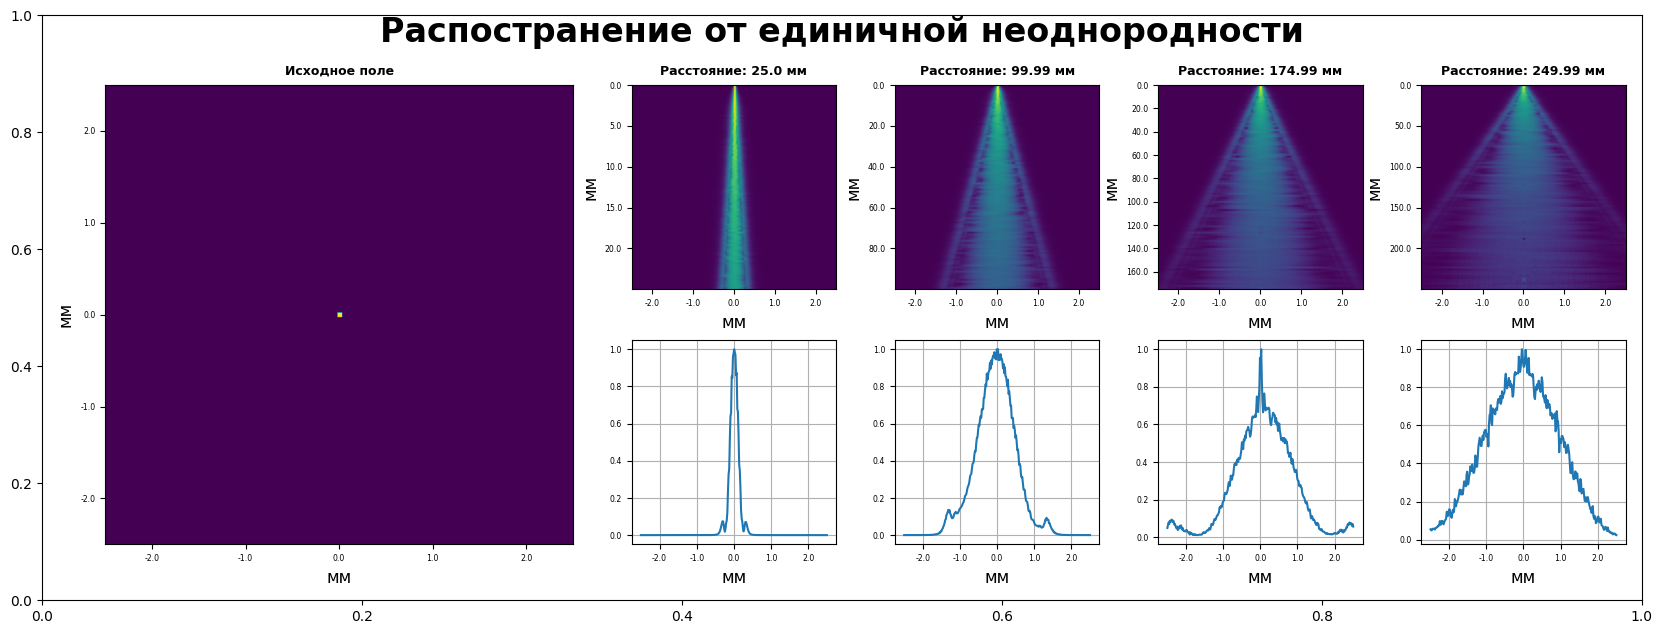

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 40)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           500.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
#optuna.delete_study(study_name="ID2NN HSC", storage="sqlite:///ID2NN.db")

In [23]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")

    #Инициализация электронной 
    electronic = timm.create_model('resnet18', pretrained=False,  in_chans=1, num_classes=10).to(device)
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN HSC", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-09 02:20:16,910] Using an existing study with name 'ID2NN HSC' instead of creating a new one.


In [24]:
study.optimize(objective, n_trials=100)

Эксперимент:
	Количетсво масок:  7
	Размер батча:      34
	Дистанция:         113.834 мм
	Скорость обучения: 0.001867677626702551
	Пропорция CELoss:  0.24310483857317317
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5754433268416076, RPI1000: -0.04432503544885065: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [12:09<00:00,  2.02it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:09<00:00,  4.25it/s]
[I 2024-05-09 02:33:38,529] Trial 20 finished with value: 18.49 and parameters: {'masks amount': 7, 'batch size': 34, 'distance': 0.11383391880323203, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      28
	Дистанция:         136.829 мм
	Скорость обучения: 1.641517507475354e-05
	Пропорция CELoss:  0.5140958345385691
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1727594181310184, RPI1000: -0.024475764977236424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1786/1786 [07:17<00:00,  4.08it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:47<00:00,  7.61it/s]
[I 2024-05-09 02:41:45,238] Trial 21 finished with value: 18.83 and parameters: {'masks amount': 4, 'batch size': 28, 'distance': 0.13682908534644922, 'lear

Эксперимент:
	Количетсво масок:  6
	Размер батча:      25
	Дистанция:         102.451 мм
	Скорость обучения: 0.0033742088418374366
	Пропорция CELoss:  0.6942473027642462
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5272448250161594, RPI1000: -0.08677979838961773: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:43<00:00,  3.11it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.53it/s]
[I 2024-05-09 02:53:32,932] Trial 22 finished with value: 21.21 and parameters: {'masks amount': 6, 'batch size': 25, 'distance': 0.10245146258119686, 'lear

Эксперимент:
	Количетсво масок:  7
	Размер батча:      27
	Дистанция:         100.022 мм
	Скорость обучения: 0.0007754628756402216
	Пропорция CELoss:  0.6689272709277172
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.431362005228512, RPI1000: -0.05368482420478267: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1852/1852 [11:56<00:00,  2.58it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [01:08<00:00,  5.38it/s]
[I 2024-05-09 03:06:40,531] Trial 23 finished with value: 14.92 and parameters: {'masks amount': 7, 'batch size': 27, 'distance': 0.10002224276836508, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      24
	Дистанция:         91.082 мм
	Скорость обучения: 0.003134751445662697
	Пропорция CELoss:  0.7126549161072121
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5604666266946736, RPI1000: -0.09444715368682108: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [07:20<00:00,  4.74it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:46<00:00,  9.05it/s]
[I 2024-05-09 03:14:48,698] Trial 24 finished with value: 23.41 and parameters: {'masks amount': 4, 'batch size': 24, 'distance': 0.09108230239565558, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      24
	Дистанция:         89.612 мм
	Скорость обучения: 0.0031682688025202557
	Пропорция CELoss:  0.7115051162872614
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.4955843305628116, RPI1000: -0.1124776319045357: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [07:11<00:00,  4.82it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:46<00:00,  9.05it/s]
[I 2024-05-09 03:22:48,795] Trial 25 finished with value: 20.38 and parameters: {'masks amount': 4, 'batch size': 24, 'distance': 0.08961195153364471, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      23
	Дистанция:         80.686 мм
	Скорость обучения: 0.0001623819038764281
	Пропорция CELoss:  0.5813647358964424
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2317553921698121, RPI1000: -0.039961786722098804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [07:12<00:00,  5.02it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:46<00:00,  9.41it/s]
[I 2024-05-09 03:30:49,762] Trial 26 finished with value: 24.76 and parameters: {'masks amount': 4, 'batch size': 23, 'distance': 0.08068646972340039, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      23
	Дистанция:         82.133 мм
	Скорость обучения: 0.0001951675599188409
	Пропорция CELoss:  0.5760031105706864
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2997435226844782, RPI1000: -0.040969234325163924: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [07:12<00:00,  5.03it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:46<00:00,  9.42it/s]
[I 2024-05-09 03:38:50,488] Trial 27 finished with value: 24.46 and parameters: {'masks amount': 4, 'batch size': 23, 'distance': 0.08213332708497972, 'lear

Эксперимент:
	Количетсво масок:  5
	Размер батча:      23
	Дистанция:         89.22 мм
	Скорость обучения: 0.00018764462858275
	Пропорция CELoss:  0.5815234557624986
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.273536103144219, RPI1000: -0.017209314589471877: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [08:41<00:00,  4.17it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:53<00:00,  8.10it/s]
[I 2024-05-09 03:48:27,604] Trial 28 finished with value: 18.05 and parameters: {'masks amount': 5, 'batch size': 23, 'distance': 0.0892200042051383, 'learn

Эксперимент:
	Количетсво масок:  3
	Размер батча:      22
	Дистанция:         167.469 мм
	Скорость обучения: 2.9392218371901432e-05
	Пропорция CELoss:  0.5426239735846548
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1862675683481605, RPI1000: -0.020003769513938157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [05:52<00:00,  6.44it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:39<00:00, 11.58it/s]
[I 2024-05-09 03:55:01,760] Trial 29 finished with value: 19.18 and parameters: {'masks amount': 3, 'batch size': 22, 'distance': 0.1674692588127965, 'learn

Эксперимент:
	Количетсво масок:  4
	Размер батча:      23
	Дистанция:         90.105 мм
	Скорость обучения: 0.0001534273333349708
	Пропорция CELoss:  0.8292852781066378
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7868818561755737, RPI1000: -0.04872669517985589: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [07:14<00:00,  5.00it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:46<00:00,  9.38it/s]
[I 2024-05-09 04:03:04,685] Trial 30 finished with value: 22.8 and parameters: {'masks amount': 4, 'batch size': 23, 'distance': 0.0901048124862013, 'learni

Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         83.319 мм
	Скорость обучения: 0.00017405018752319543
	Пропорция CELoss:  0.36756406409484776
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.8546994601434301, RPI1000: -0.0082266672343294: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:38<00:00,  4.59it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.85it/s]
[I 2024-05-09 04:12:39,144] Trial 31 finished with value: 18.78 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.08331853472499172, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      24
	Дистанция:         80.377 мм
	Скорость обучения: 0.00018335917036619033
	Пропорция CELoss:  0.7293302407244935
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5817688499281748, RPI1000: -0.05166262293178012: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [07:12<00:00,  4.82it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:46<00:00,  9.02it/s]
[I 2024-05-09 04:20:40,298] Trial 32 finished with value: 24.08 and parameters: {'masks amount': 4, 'batch size': 24, 'distance': 0.08037703940772964, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      24
	Дистанция:         80.05 мм
	Скорость обучения: 4.0006274208035086e-05
	Пропорция CELoss:  0.6071375461808377
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.3443358516105557, RPI1000: -0.036095952890796104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2084/2084 [07:13<00:00,  4.81it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:46<00:00,  8.99it/s]
[I 2024-05-09 04:28:42,191] Trial 33 finished with value: 21.38 and parameters: {'masks amount': 4, 'batch size': 24, 'distance': 0.0800501166441659, 'learn

Эксперимент:
	Количетсво масок:  3
	Размер батча:      27
	Дистанция:         94.294 мм
	Скорость обучения: 1.0029433751533985e-05
	Пропорция CELoss:  0.49312111464206554
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1344606447272665, RPI1000: -0.0247130224205588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1852/1852 [05:48<00:00,  5.32it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:38<00:00,  9.58it/s]
[I 2024-05-09 04:35:11,206] Trial 34 finished with value: 19.89 and parameters: {'masks amount': 3, 'batch size': 27, 'distance': 0.09429382189240632, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      23
	Дистанция:         92.957 мм
	Скорость обучения: 0.0002141635141185575
	Пропорция CELoss:  0.7552950485335798
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6579165221605596, RPI1000: -0.03536008571857005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [07:14<00:00,  5.00it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:46<00:00,  9.30it/s]
[I 2024-05-09 04:43:14,384] Trial 35 finished with value: 22.23 and parameters: {'masks amount': 4, 'batch size': 23, 'distance': 0.09295691665537804, 'lear

Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         86.146 мм
	Скорость обучения: 0.00010631448893476129
	Пропорция CELoss:  0.8464215587992014
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.921449489728008, RPI1000: -0.016728597804957043: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:39<00:00,  4.59it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.84it/s]
[I 2024-05-09 04:52:49,430] Trial 36 finished with value: 16.6 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.08614647154662433, 'learn

Эксперимент:
	Количетсво масок:  4
	Размер батча:      31
	Дистанция:         95.777 мм
	Скорость обучения: 0.017219348068829236
	Пропорция CELoss:  0.5724801972540651
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1749712353698862, RPI1000: -0.09933982228607333: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [07:11<00:00,  3.74it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:45<00:00,  7.05it/s]
[I 2024-05-09 05:00:48,736] Trial 37 finished with value: 24.08 and parameters: {'masks amount': 4, 'batch size': 31, 'distance': 0.09577654439104508, 'lear

Эксперимент:
	Количетсво масок:  5
	Размер батча:      31
	Дистанция:         159.727 мм
	Скорость обучения: 0.03763862515901679
	Пропорция CELoss:  0.5867114711938162
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2851846754631466, RPI1000: -0.09253642858371747: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [08:39<00:00,  3.10it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:53<00:00,  6.07it/s]
[I 2024-05-09 05:10:23,677] Trial 38 finished with value: 17.87 and parameters: {'masks amount': 5, 'batch size': 31, 'distance': 0.15972728472687964, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      34
	Дистанция:         96.626 мм
	Скорость обучения: 5.355179309342502e-05
	Пропорция CELoss:  0.26574482386616416
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6370535065662105, RPI1000: -0.032492668700409434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [05:43<00:00,  4.28it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:38<00:00,  7.66it/s]
[I 2024-05-09 05:16:48,062] Trial 39 finished with value: 24.54 and parameters: {'masks amount': 3, 'batch size': 34, 'distance': 0.09662596902588796, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         85.661 мм
	Скорость обучения: 4.4663664167728745e-05
	Пропорция CELoss:  0.263449373132481
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6063724928545093, RPI1000: -0.03877621388166033: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:46<00:00,  3.91it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  7.06it/s]
[I 2024-05-09 05:23:14,496] Trial 40 finished with value: 25.87 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.08566063703008776, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      38
	Дистанция:         114.425 мм
	Скорость обучения: 5.2222552540491445e-05
	Пропорция CELoss:  0.2744132862753914
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6346669983261057, RPI1000: -0.028606723849767448: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [05:44<00:00,  3.82it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:38<00:00,  6.94it/s]
[I 2024-05-09 05:29:38,981] Trial 41 finished with value: 23.04 and parameters: {'masks amount': 3, 'batch size': 38, 'distance': 0.11442527157518148, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         84.346 мм
	Скорость обучения: 9.37132516754596e-05
	Пропорция CELoss:  0.1975550305048816
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.46890963594434465, RPI1000: -0.032723476376267976: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:45<00:00,  4.02it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:38<00:00,  7.28it/s]
[I 2024-05-09 05:36:05,046] Trial 42 finished with value: 26.62 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.08434558626462368, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         86.261 мм
	Скорость обучения: 8.952716428407223e-05
	Пропорция CELoss:  0.19269216832524855
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4666652905208247, RPI1000: -0.03507885656429209: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:44<00:00,  3.92it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  7.07it/s]
[I 2024-05-09 05:42:30,233] Trial 43 finished with value: 27.24 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.08626135541358812, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         86.074 мм
	Скорость обучения: 2.830679326541946e-05
	Пропорция CELoss:  0.19753190698122763
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4916048119397828, RPI1000: -0.028242094163620418: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:46<00:00,  4.01it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:37<00:00,  7.36it/s]
[I 2024-05-09 05:48:55,971] Trial 44 finished with value: 25.02 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.08607415720440066, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         89.258 мм
	Скорость обучения: 2.6022177934216022e-05
	Пропорция CELoss:  0.11873993149617011
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3339257281105401, RPI1000: -0.015665715076833564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:44<00:00,  3.92it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  7.09it/s]
[I 2024-05-09 05:55:20,890] Trial 45 finished with value: 24.27 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.08925842002151434, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         86.496 мм
	Скорость обучения: 0.00010228900914265585
	Пропорция CELoss:  0.21977434412408148
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5220849407848838, RPI1000: -0.03349345703173309: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:45<00:00,  4.02it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:37<00:00,  7.39it/s]
[I 2024-05-09 06:01:46,124] Trial 46 finished with value: 26.49 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.08649567913890956, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         86.596 мм
	Скорость обучения: 8.387511725627365e-05
	Пропорция CELoss:  0.17386524117522295
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4214560622861225, RPI1000: -0.031640928992451405: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:46<00:00,  4.01it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:37<00:00,  7.38it/s]
[I 2024-05-09 06:08:11,915] Trial 47 finished with value: 26.95 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.08659639539055185, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      40
	Дистанция:         135.02 мм
	Скорость обучения: 0.00010525169893894005
	Пропорция CELoss:  0.028011201019728926
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1463070046047783, RPI1000: -0.0045672303911057045: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:43<00:00,  3.64it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.59it/s]
[I 2024-05-09 06:14:35,418] Trial 48 finished with value: 20.72 and parameters: {'masks amount': 3, 'batch size': 40, 'distance': 0.13502033574536235, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      35
	Дистанция:         106.219 мм
	Скорость обучения: 7.938189767447661e-05
	Пропорция CELoss:  0.20088730362718674
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4894974867602254, RPI1000: -0.022638251236218064: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [05:47<00:00,  4.12it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:37<00:00,  7.53it/s]
[I 2024-05-09 06:21:02,472] Trial 49 finished with value: 25.69 and parameters: {'masks amount': 3, 'batch size': 35, 'distance': 0.10621854094277022, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         98.502 мм
	Скорость обучения: 1.3600895943941809e-05
	Пропорция CELoss:  0.1394958611608963
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3789615988381373, RPI1000: -0.016133059174482305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:44<00:00,  3.92it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:37<00:00,  7.15it/s]
[I 2024-05-09 06:27:27,393] Trial 50 finished with value: 20.97 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.09850209273530185, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      40
	Дистанция:         86.847 мм
	Скорость обучения: 4.003956917711122e-05
	Пропорция CELoss:  0.32837948365306585
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.7278079986975179, RPI1000: -0.05446833880120393: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:43<00:00,  3.64it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.57it/s]
[I 2024-05-09 06:33:50,988] Trial 51 finished with value: 25.83 and parameters: {'masks amount': 3, 'batch size': 40, 'distance': 0.08684674741709163, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      40
	Дистанция:         87.015 мм
	Скорость обучения: 4.187074153658357e-05
	Пропорция CELoss:  0.3165152779106213
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.7079405895423949, RPI1000: -0.055562385634462384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:06<00:00,  3.41it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:39<00:00,  6.38it/s]
[I 2024-05-09 06:40:38,830] Trial 52 finished with value: 25.66 and parameters: {'masks amount': 3, 'batch size': 40, 'distance': 0.08701533360186428, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      38
	Дистанция:         92.215 мм
	Скорость обучения: 7.526247006253337e-05
	Пропорция CELoss:  0.1910570112949142
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.45563762062781815, RPI1000: -0.030278233762544064: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [05:49<00:00,  3.76it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:39<00:00,  6.75it/s]
[I 2024-05-09 06:47:09,347] Trial 53 finished with value: 26.63 and parameters: {'masks amount': 3, 'batch size': 38, 'distance': 0.09221491585876007, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      38
	Дистанция:         93.363 мм
	Скорость обучения: 0.00010047909972379657
	Пропорция CELoss:  0.19190598103934792
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4674924730495568, RPI1000: -0.03431542275560246: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [05:49<00:00,  3.77it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:39<00:00,  6.71it/s]
[I 2024-05-09 06:53:39,714] Trial 54 finished with value: 23.04 and parameters: {'masks amount': 3, 'batch size': 38, 'distance': 0.09336316853242367, 'lear

Эксперимент:
	Количетсво масок:  9
	Размер батча:      36
	Дистанция:         100.519 мм
	Скорость обучения: 7.454209086156952e-05
	Пропорция CELoss:  0.0884761183790409
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2795308532233586, RPI1000: -0.002405713795138414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [14:04<00:00,  1.64it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:23<00:00,  3.33it/s]
[I 2024-05-09 07:09:09,875] Trial 55 finished with value: 12.92 and parameters: {'masks amount': 9, 'batch size': 36, 'distance': 0.10051883554906653, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      34
	Дистанция:         85.144 мм
	Скорость обучения: 5.806130557429669e-05
	Пропорция CELoss:  0.009646936121139205
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.10367668680695792, RPI1000: -0.004723767039074108: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [05:42<00:00,  4.30it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:38<00:00,  7.73it/s]
[I 2024-05-09 07:15:32,313] Trial 56 finished with value: 26.19 and parameters: {'masks amount': 3, 'batch size': 34, 'distance': 0.08514394853715407, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      33
	Дистанция:         92.99 мм
	Скорость обучения: 0.00028154007401526336
	Пропорция CELoss:  0.02859693230313968
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.14585084622084873, RPI1000: -0.0026852869741807207: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [07:11<00:00,  3.51it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:45<00:00,  6.70it/s]
[I 2024-05-09 07:23:31,230] Trial 57 finished with value: 19.72 and parameters: {'masks amount': 4, 'batch size': 33, 'distance': 0.09298987976966992, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      35
	Дистанция:         108.378 мм
	Скорость обучения: 0.0001251237880836928
	Пропорция CELoss:  0.07638645838272776
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2599922572345247, RPI1000: -0.005372014539240447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [05:40<00:00,  4.20it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:38<00:00,  7.48it/s]
[I 2024-05-09 07:29:52,126] Trial 58 finished with value: 13.73 and parameters: {'masks amount': 3, 'batch size': 35, 'distance': 0.10837847444883743, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      38
	Дистанция:         123.028 мм
	Скорость обучения: 0.0002891753225321352
	Пропорция CELoss:  0.162936468060617
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.40516212807483687, RPI1000: -0.021253114529868597: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [05:45<00:00,  3.81it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:37<00:00,  6.98it/s]
[I 2024-05-09 07:36:17,189] Trial 59 finished with value: 24.65 and parameters: {'masks amount': 3, 'batch size': 38, 'distance': 0.12302839790575583, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      36
	Дистанция:         179.746 мм
	Скорость обучения: 2.2270371687987058e-05
	Пропорция CELoss:  0.10515110105156902
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.31010133131452217, RPI1000: -0.006892152014376247: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [07:14<00:00,  3.20it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:45<00:00,  6.10it/s]
[I 2024-05-09 07:44:19,254] Trial 60 finished with value: 17.59 and parameters: {'masks amount': 4, 'batch size': 36, 'distance': 0.179745889815476, 'learni

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         83.911 мм
	Скорость обучения: 6.447099230059828e-05
	Пропорция CELoss:  0.04825230765755267
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.18896391314431232, RPI1000: -0.01188426284135139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:44<00:00,  3.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:38<00:00,  6.73it/s]
[I 2024-05-09 07:50:44,208] Trial 61 finished with value: 26.48 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.08391068910347624, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         85.374 мм
	Скорость обучения: 6.94667782244619e-05
	Пропорция CELoss:  0.05179917828009403
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17855583165960148, RPI1000: -0.011655265023942929: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:45<00:00,  3.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:37<00:00,  6.76it/s]
[I 2024-05-09 07:57:09,385] Trial 62 finished with value: 26.37 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.08537442868570727, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         91.895 мм
	Скорость обучения: 7.536038196992278e-05
	Пропорция CELoss:  0.16606143956525676
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.42310445523355367, RPI1000: -0.027730748826458953: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:45<00:00,  3.71it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:38<00:00,  6.74it/s]
[I 2024-05-09 08:03:34,916] Trial 63 finished with value: 26.16 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.09189543691905544, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         84.211 мм
	Скорость обучения: 0.00012586428338686798
	Пропорция CELoss:  0.05324370874932907
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.19144421905772033, RPI1000: -0.013374305674503763: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:44<00:00,  3.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:37<00:00,  6.78it/s]
[I 2024-05-09 08:09:59,491] Trial 64 finished with value: 26.4 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.08421078245733572, 'learn

Эксперимент:
	Количетсво масок:  3
	Размер батча:      38
	Дистанция:         83.015 мм
	Скорость обучения: 0.00012664508764087076
	Пропорция CELoss:  0.22045674062682433
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5108878518468186, RPI1000: -0.03675610714152239: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [05:45<00:00,  3.81it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:37<00:00,  6.97it/s]
[I 2024-05-09 08:16:24,688] Trial 65 finished with value: 26.74 and parameters: {'masks amount': 3, 'batch size': 38, 'distance': 0.08301501763478686, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      38
	Дистанция:         102.203 мм
	Скорость обучения: 3.248577336856332e-05
	Пропорция CELoss:  0.2102017826514204
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5573291109757887, RPI1000: -0.011446694081572664: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [07:17<00:00,  3.01it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:45<00:00,  5.82it/s]
[I 2024-05-09 08:24:29,463] Trial 66 finished with value: 12.83 and parameters: {'masks amount': 4, 'batch size': 38, 'distance': 0.10220250218307449, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      37
	Дистанция:         89.625 мм
	Скорость обучения: 9.18658124136876e-05
	Пропорция CELoss:  0.2325000276333319
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5736718033025827, RPI1000: -0.023698490364211844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [07:24<00:00,  3.04it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  6.00it/s]
[I 2024-05-09 08:32:41,329] Trial 67 finished with value: 21.19 and parameters: {'masks amount': 4, 'batch size': 37, 'distance': 0.08962542702552942, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      35
	Дистанция:         97.961 мм
	Скорость обучения: 0.0002569310722631615
	Пропорция CELoss:  0.13221188790360977
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.361971016898045, RPI1000: -0.00865723401015651: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [05:45<00:00,  4.14it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:38<00:00,  7.48it/s]
[I 2024-05-09 08:39:07,217] Trial 68 finished with value: 22.13 and parameters: {'masks amount': 3, 'batch size': 35, 'distance': 0.097961201748613, 'learni

Эксперимент:
	Количетсво масок:  10
	Размер батча:      36
	Дистанция:         83.243 мм
	Скорость обучения: 0.0004771350388158154
	Пропорция CELoss:  0.38039663981370986
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.9263188177804419, RPI1000: -0.009271883707750663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [15:40<00:00,  1.48it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:35<00:00,  2.91it/s]
[I 2024-05-09 08:56:25,742] Trial 69 finished with value: 10.0 and parameters: {'masks amount': 10, 'batch size': 36, 'distance': 0.08324345414013434, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      38
	Дистанция:         95.199 мм
	Скорость обучения: 0.000135832109607494
	Пропорция CELoss:  0.28941311828959443
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6595090949129185, RPI1000: -0.02264430365614649: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [07:22<00:00,  2.97it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:45<00:00,  5.86it/s]
[I 2024-05-09 09:04:35,055] Trial 70 finished with value: 22.44 and parameters: {'masks amount': 4, 'batch size': 38, 'distance': 0.09519887639840316, 'lear

Эксперимент:
	Количетсво масок:  8
	Размер батча:      37
	Дистанция:         80.379 мм
	Скорость обучения: 1.591632379344365e-05
	Пропорция CELoss:  0.2328295700705248
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6029155081032789, RPI1000: -0.006315350386980827: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [12:56<00:00,  1.74it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:17<00:00,  3.51it/s]
[I 2024-05-09 09:18:50,527] Trial 71 finished with value: 14.66 and parameters: {'masks amount': 8, 'batch size': 37, 'distance': 0.08037901227179176, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         82.816 мм
	Скорость обучения: 0.00013479777163039755
	Пропорция CELoss:  0.17131794738181438
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4158882340956068, RPI1000: -0.03331607811048827: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:44<00:00,  3.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:37<00:00,  6.77it/s]
[I 2024-05-09 09:25:15,460] Trial 72 finished with value: 25.29 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.08281590938097161, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      39
	Дистанция:         88.865 мм
	Скорость обучения: 6.050498848154119e-05
	Пропорция CELoss:  0.05712472211808279
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.20311729450840954, RPI1000: -0.010957220858959525: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [05:44<00:00,  3.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:37<00:00,  6.78it/s]
[I 2024-05-09 09:31:39,979] Trial 73 finished with value: 25.03 and parameters: {'masks amount': 3, 'batch size': 39, 'distance': 0.08886463421930377, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      40
	Дистанция:         84.258 мм
	Скорость обучения: 0.00011874278196869242
	Пропорция CELoss:  0.09278221544501586
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2617704513624422, RPI1000: -0.018339403249554624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:44<00:00,  3.63it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.64it/s]
[I 2024-05-09 09:38:03,595] Trial 74 finished with value: 26.81 and parameters: {'masks amount': 3, 'batch size': 40, 'distance': 0.08425750233952224, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      40
	Дистанция:         92.451 мм
	Скорость обучения: 8.895417106633376e-05
	Пропорция CELoss:  0.09712078932802073
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.26687092985361216, RPI1000: -0.0189005480776291: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:44<00:00,  3.63it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.63it/s]
[I 2024-05-09 09:44:27,994] Trial 75 finished with value: 25.12 and parameters: {'masks amount': 3, 'batch size': 40, 'distance': 0.09245098886662848, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      38
	Дистанция:         152.856 мм
	Скорость обучения: 0.0002322324264860673
	Пропорция CELoss:  0.14480238486892885
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.39443060904054417, RPI1000: -0.010541964451776329: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [07:14<00:00,  3.03it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:45<00:00,  5.82it/s]
[I 2024-05-09 09:52:29,632] Trial 76 finished with value: 19.42 and parameters: {'masks amount': 4, 'batch size': 38, 'distance': 0.152855998467254, 'learni

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         174.658 мм
	Скорость обучения: 0.0005711285906308762
	Пропорция CELoss:  0.2314501682570157
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5919354139037412, RPI1000: -0.009989782185863029: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:44<00:00,  4.03it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:38<00:00,  7.26it/s]
[I 2024-05-09 09:58:54,112] Trial 77 finished with value: 15.66 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.17465831239328372, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      33
	Дистанция:         88.071 мм
	Скорость обучения: 0.001250067263050877
	Пропорция CELoss:  0.00044843882221962117
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.08790392197862047, RPI1000: -0.004134096895241474: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [05:41<00:00,  4.44it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:38<00:00,  7.97it/s]
[I 2024-05-09 10:05:15,676] Trial 78 finished with value: 27.71 and parameters: {'masks amount': 3, 'batch size': 33, 'distance': 0.08807072356698555, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      33
	Дистанция:         87.984 мм
	Скорость обучения: 0.0012192825530190497
	Пропорция CELoss:  0.35173481894288233
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.8677302893428719, RPI1000: -0.04554650651729114: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [07:12<00:00,  3.50it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:45<00:00,  6.69it/s]
[I 2024-05-09 10:13:15,611] Trial 79 finished with value: 23.95 and parameters: {'masks amount': 4, 'batch size': 33, 'distance': 0.08798384124914842, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      35
	Дистанция:         95.153 мм
	Скорость обучения: 0.00035510012263000436
	Пропорция CELoss:  0.10898976818573475
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3064480934376048, RPI1000: -0.009554563933429062: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [05:44<00:00,  4.14it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:37<00:00,  7.54it/s]
[I 2024-05-09 10:19:40,300] Trial 80 finished with value: 22.78 and parameters: {'masks amount': 3, 'batch size': 35, 'distance': 0.09515347799724344, 'lear

Эксперимент:
	Количетсво масок:  6
	Размер батча:      34
	Дистанция:         91.813 мм
	Скорость обучения: 0.0021339480674868513
	Пропорция CELoss:  0.2976675843457802
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.6996156275971236, RPI1000: -0.032549409336536814: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [10:00<00:00,  2.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:00<00:00,  4.89it/s]
[I 2024-05-09 10:30:43,381] Trial 81 finished with value: 20.57 and parameters: {'masks amount': 6, 'batch size': 34, 'distance': 0.09181271813849586, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         82.373 мм
	Скорость обучения: 0.0007216476120167598
	Пропорция CELoss:  0.010063113371183097
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.10051908800050718, RPI1000: -0.00617562737745597: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:46<00:00,  3.91it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:37<00:00,  7.18it/s]
[I 2024-05-09 10:37:09,225] Trial 82 finished with value: 28.16 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.08237293922660772, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      37
	Дистанция:         81.599 мм
	Скорость обучения: 0.000790083478179183
	Пропорция CELoss:  0.0015925054953019116
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.08846881788985997, RPI1000: -0.00459037881044797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [05:45<00:00,  3.91it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:37<00:00,  7.13it/s]
[I 2024-05-09 10:43:35,007] Trial 83 finished with value: 26.39 and parameters: {'masks amount': 3, 'batch size': 37, 'distance': 0.0815989904358664, 'learn

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         88.141 мм
	Скорость обучения: 0.002373867507412333
	Пропорция CELoss:  0.17997738631918686
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.41185602975479907, RPI1000: -0.04676942889608137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [05:47<00:00,  4.00it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:37<00:00,  7.32it/s]
[I 2024-05-09 10:50:02,159] Trial 84 finished with value: 28.13 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.08814137541168438, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      33
	Дистанция:         88.453 мм
	Скорость обучения: 0.005933358930461469
	Пропорция CELoss:  0.1717177485386824
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.42564020841821876, RPI1000: -0.037392371672980415: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [05:42<00:00,  4.43it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:37<00:00,  8.05it/s]
[I 2024-05-09 10:56:23,971] Trial 85 finished with value: 27.33 and parameters: {'masks amount': 3, 'batch size': 33, 'distance': 0.08845263675879074, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      32
	Дистанция:         90.517 мм
	Скорость обучения: 0.004425394175507936
	Пропорция CELoss:  0.16939448356440154
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.42165015938041517, RPI1000: -0.034503470976691535: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [07:12<00:00,  3.61it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:45<00:00,  6.89it/s]
[I 2024-05-09 11:04:23,981] Trial 86 finished with value: 27.63 and parameters: {'masks amount': 4, 'batch size': 32, 'distance': 0.09051745841236628, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      30
	Дистанция:         98.86 мм
	Скорость обучения: 0.006492561291120482
	Пропорция CELoss:  0.15180474943223565
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3887405262807332, RPI1000: -0.023379851383555472: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [07:13<00:00,  3.84it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:45<00:00,  7.28it/s]
[I 2024-05-09 11:12:25,455] Trial 87 finished with value: 24.86 and parameters: {'masks amount': 4, 'batch size': 30, 'distance': 0.09885973991860109, 'lear

Эксперимент:
	Количетсво масок:  5
	Размер батча:      32
	Дистанция:         89.931 мм
	Скорость обучения: 0.004161706403743037
	Пропорция CELoss:  0.07645487193313862
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.24349765187788183, RPI1000: -0.014072486795972266: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [08:41<00:00,  3.00it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:52<00:00,  5.92it/s]
[I 2024-05-09 11:22:01,614] Trial 88 finished with value: 24.65 and parameters: {'masks amount': 5, 'batch size': 32, 'distance': 0.08993111003072603, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      33
	Дистанция:         87.906 мм
	Скорость обучения: 0.0025750305859912133
	Пропорция CELoss:  0.11936711196632847
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3166543435306136, RPI1000: -0.02409130493884476: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [07:13<00:00,  3.50it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:45<00:00,  6.68it/s]
[I 2024-05-09 11:30:02,514] Trial 89 finished with value: 24.89 and parameters: {'masks amount': 4, 'batch size': 33, 'distance': 0.08790553727403563, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         81.317 мм
	Скорость обучения: 0.01291864205014686
	Пропорция CELoss:  0.028751777610458686
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1417346345582497, RPI1000: -0.010435520480781335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:42<00:00,  4.71it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:37<00:00,  8.54it/s]
[I 2024-05-09 11:36:24,917] Trial 90 finished with value: 29.46 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08131719240740773, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      31
	Дистанция:         80.087 мм
	Скорость обучения: 0.01646317058795584
	Пропорция CELoss:  0.03997156494103066
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1618692344431413, RPI1000: -0.012024346189734395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [07:12<00:00,  3.73it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:45<00:00,  7.13it/s]
[I 2024-05-09 11:44:24,798] Trial 91 finished with value: 25.62 and parameters: {'masks amount': 4, 'batch size': 31, 'distance': 0.08008737249831131, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         82.692 мм
	Скорость обучения: 0.010307799803591712
	Пропорция CELoss:  0.0009449638176080023
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.0873017202911357, RPI1000: -0.005513685913239694: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [05:45<00:00,  4.83it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:38<00:00,  8.79it/s]
[I 2024-05-09 11:50:49,722] Trial 92 finished with value: 26.55 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.08269231127308878, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         87.985 мм
	Скорость обучения: 0.001403272547134584
	Пропорция CELoss:  0.0775924964461982
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.22712905010496953, RPI1000: -0.021194447246202532: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:42<00:00,  4.56it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:38<00:00,  8.22it/s]
[I 2024-05-09 11:57:12,180] Trial 93 finished with value: 29.02 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.0879846477628265, 'learn

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         87.614 мм
	Скорость обучения: 0.00510113284496298
	Пропорция CELoss:  0.02396894576261749
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12784592323648208, RPI1000: -0.009060506372794066: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:43<00:00,  4.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.47it/s]
[I 2024-05-09 12:03:35,263] Trial 94 finished with value: 29.54 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08761434798966601, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         90.175 мм
	Скорость обучения: 0.004284868280586492
	Пропорция CELoss:  0.024897775016834166
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12735310359572083, RPI1000: -0.009696623429843596: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:42<00:00,  4.56it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:37<00:00,  8.26it/s]
[I 2024-05-09 12:09:57,774] Trial 95 finished with value: 27.75 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.09017478967518144, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      29
	Дистанция:         96.265 мм
	Скорость обучения: 0.004699303681630154
	Пропорция CELoss:  0.033001599507744964
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1538204583187811, RPI1000: -0.01058420603218458: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1725/1725 [05:45<00:00,  4.99it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:38<00:00,  9.06it/s]
[I 2024-05-09 12:16:23,284] Trial 96 finished with value: 26.43 and parameters: {'masks amount': 3, 'batch size': 29, 'distance': 0.09626537016094575, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         91.394 мм
	Скорость обучения: 0.0016190548752863182
	Пропорция CELoss:  0.018009072835387892
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.11952359139926003, RPI1000: -0.0076848878350293595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:43<00:00,  4.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.49it/s]
[I 2024-05-09 12:22:46,744] Trial 97 finished with value: 28.27 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.09139436596339941, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         90.458 мм
	Скорость обучения: 0.001572659792939417
	Пропорция CELoss:  0.023733272310823825
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.13980115572243648, RPI1000: -0.0017657052308934138: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:39<00:00,  4.61it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:38<00:00,  8.15it/s]
[I 2024-05-09 12:29:06,317] Trial 98 finished with value: 16.16 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.09045833142014552, 'lear

Эксперимент:
	Количетсво масок:  4
	Размер батча:      31
	Дистанция:         100.939 мм
	Скорость обучения: 0.0009239569203104655
	Пропорция CELoss:  0.06396259013963324
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.22004722114997063, RPI1000: -0.006325214795895553: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [07:12<00:00,  3.73it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:45<00:00,  7.08it/s]
[I 2024-05-09 12:37:06,507] Trial 99 finished with value: 22.29 and parameters: {'masks amount': 4, 'batch size': 31, 'distance': 0.10093868393562004, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         94.025 мм
	Скорость обучения: 0.0050850671993598615
	Пропорция CELoss:  0.02208304188659332
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12564245716999675, RPI1000: -0.005974625008352781: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:42<00:00,  4.71it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:37<00:00,  8.52it/s]
[I 2024-05-09 12:43:28,831] Trial 100 finished with value: 24.02 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.09402516227553459, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      29
	Дистанция:         88.083 мм
	Скорость обучения: 0.011826740663391726
	Пропорция CELoss:  0.07845439964024611
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.24198460918889897, RPI1000: -0.016133279564173514: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1725/1725 [05:45<00:00,  4.99it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:38<00:00,  9.03it/s]
[I 2024-05-09 12:49:54,664] Trial 101 finished with value: 23.81 and parameters: {'masks amount': 3, 'batch size': 29, 'distance': 0.08808273134080714, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      33
	Дистанция:         90.807 мм
	Скорость обучения: 0.00773478320644715
	Пропорция CELoss:  0.12118957282578924
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3371343475007903, RPI1000: -0.030241054999085682: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [05:45<00:00,  4.38it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:39<00:00,  7.60it/s]
[I 2024-05-09 12:56:22,174] Trial 102 finished with value: 29.08 and parameters: {'masks amount': 3, 'batch size': 33, 'distance': 0.09080701326284041, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      33
	Дистанция:         90.637 мм
	Скорость обучения: 0.0026112522847084813
	Пропорция CELoss:  0.016603495029255226
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.11625438220776366, RPI1000: -0.008887564091983432: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [05:56<00:00,  4.25it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:39<00:00,  7.73it/s]
[I 2024-05-09 13:02:59,813] Trial 103 finished with value: 29.24 and parameters: {'masks amount': 3, 'batch size': 33, 'distance': 0.09063704852509938, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         90.739 мм
	Скорость обучения: 0.0036557324175657234
	Пропорция CELoss:  0.016687009063765534
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.11714673169454022, RPI1000: -0.008327282882879006: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:51<00:00,  4.44it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:39<00:00,  7.96it/s]
[I 2024-05-09 13:09:32,812] Trial 104 finished with value: 28.83 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.0907388085971239, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         104.841 мм
	Скорость обучения: 0.002592584073975313
	Пропорция CELoss:  0.02374331031840523
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.12760725275715465, RPI1000: -0.010003719830742086: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:51<00:00,  4.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:39<00:00,  7.98it/s]
[I 2024-05-09 13:16:05,685] Trial 105 finished with value: 26.66 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.10484128421835648, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         96.889 мм
	Скорость обучения: 0.0013828442201927042
	Пропорция CELoss:  0.010375206632401365
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.10063137863949059, RPI1000: -0.005462158290083033: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [05:56<00:00,  4.68it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:40<00:00,  8.33it/s]
[I 2024-05-09 13:22:44,279] Trial 106 finished with value: 27.95 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.09688883436619833, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         94.209 мм
	Скорость обучения: 0.003553867211557666
	Пропорция CELoss:  0.059506682518905736
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1855936926391314, RPI1000: -0.017988303462817056: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [05:55<00:00,  4.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:39<00:00,  8.44it/s]
[I 2024-05-09 13:29:21,366] Trial 107 finished with value: 30.68 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.09420945303217396, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         97.345 мм
	Скорость обучения: 0.00798439557446124
	Пропорция CELoss:  0.06063837400568212
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1957625642505555, RPI1000: -0.014994095363801658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [05:46<00:00,  4.81it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:38<00:00,  8.75it/s]
[I 2024-05-09 13:35:47,899] Trial 108 finished with value: 27.02 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.09734546015653414, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      28
	Дистанция:         111.808 мм
	Скорость обучения: 0.001562047369271569
	Пропорция CELoss:  0.12950405742072701
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3401130258871093, RPI1000: -0.024188638652148563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1786/1786 [05:45<00:00,  5.17it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:38<00:00,  9.37it/s]
[I 2024-05-09 13:42:13,472] Trial 109 finished with value: 26.83 and parameters: {'masks amount': 3, 'batch size': 28, 'distance': 0.1118078896756664, 'lear

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         99.467 мм
	Скорость обучения: 0.0020175638991186667
	Пропорция CELoss:  0.044482223732146345
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.16465557345858267, RPI1000: -0.013254546599383904: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [05:44<00:00,  4.84it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:38<00:00,  8.73it/s]
[I 2024-05-09 13:48:38,395] Trial 110 finished with value: 27.24 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.09946687238292355, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         93.949 мм
	Скорость обучения: 0.002866940625949871
	Пропорция CELoss:  0.08229059640824705
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2364701580875615, RPI1000: -0.023286662919543063: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:43<00:00,  4.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.46it/s]
[I 2024-05-09 13:55:01,996] Trial 111 finished with value: 26.78 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.09394888250495424, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      32
	Дистанция:         91.164 мм
	Скорость обучения: 0.003697409019880028
	Пропорция CELoss:  0.01198382934836588
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.10884493791947772, RPI1000: -0.007857450112971849: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [05:42<00:00,  4.57it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:37<00:00,  8.28it/s]
[I 2024-05-09 14:01:23,955] Trial 112 finished with value: 27.34 and parameters: {'masks amount': 3, 'batch size': 32, 'distance': 0.09116408304024613, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      29
	Дистанция:         95.065 мм
	Скорость обучения: 0.0077822429189641435
	Пропорция CELoss:  0.03860622374625976
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.16166381640581434, RPI1000: -0.010424973788248205: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1725/1725 [05:45<00:00,  4.99it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:38<00:00,  9.05it/s]
[I 2024-05-09 14:07:49,493] Trial 113 finished with value: 25.71 and parameters: {'masks amount': 3, 'batch size': 29, 'distance': 0.09506535286949994, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         85.505 мм
	Скорость обучения: 0.003504053053318991
	Пропорция CELoss:  0.06974317111980102
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.20849950076170443, RPI1000: -0.02042260838593964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:43<00:00,  4.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.43it/s]
[I 2024-05-09 14:14:12,703] Trial 114 finished with value: 28.66 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08550477542523492, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         85.445 мм
	Скорость обучения: 0.0022354633415176033
	Пропорция CELoss:  0.099385240134168
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2607090847550968, RPI1000: -0.024899291196230335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:44<00:00,  4.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:37<00:00,  8.51it/s]
[I 2024-05-09 14:20:36,779] Trial 115 finished with value: 29.67 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08544523869286327, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         85.627 мм
	Скорость обучения: 0.0023999791810224713
	Пропорция CELoss:  0.1069411566830046
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.27854908110947196, RPI1000: -0.02560321471089178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:43<00:00,  4.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.50it/s]
[I 2024-05-09 14:27:00,509] Trial 116 finished with value: 28.65 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08562673009753363, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         85.257 мм
	Скорость обучения: 0.0031427861049945155
	Пропорция CELoss:  0.10672286542336323
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2853968925171504, RPI1000: -0.024296191947345152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:48<00:00,  4.63it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:39<00:00,  8.08it/s]
[I 2024-05-09 14:33:30,492] Trial 117 finished with value: 30.05 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08525683987844306, 'lea

Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         85.003 мм
	Скорость обучения: 0.0033866256720174646
	Пропорция CELoss:  0.10758519425549379
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2890354263313866, RPI1000: -0.02877448802231436: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [05:53<00:00,  4.56it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:38<00:00,  8.40it/s]
[I 2024-05-09 14:40:04,608] Trial 118 finished with value: 29.86 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.08500344996571546, 'lea

Эксперимент:
	Количетсво масок:  4
	Размер батча:      31
	Дистанция:         85.41 мм
	Скорость обучения: 0.0034774074559638986
	Пропорция CELoss:  0.11261356761257427
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.32718703282647055, RPI1000: -0.006901694645542528: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [07:16<00:00,  3.70it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:46<00:00,  6.89it/s]
[I 2024-05-09 14:48:09,931] Trial 119 finished with value: 18.78 and parameters: {'masks amount': 4, 'batch size': 31, 'distance': 0.08541022648804784, 'lea

In [25]:
print("Лучшие гиперпараметры:", study.best_trial.params)

Лучшие гиперпараметры: {'masks amount': 3, 'batch size': 30, 'distance': 0.09420945303217396, 'learning rate': 0.003553867211557666, 'cross entorpy proportion': 0.059506682518905736, 'optimizer type': 'Adam'}


In [26]:
len(study.trials)

120